In [ ]:
#Mounting Google Drive to obtain Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

mostdisliked="/content/drive/Shareddrives/Capstone - James Mete - Sashaank Sekar - Jenna Mekled/Data/mostdisliked_500000.csv"
mostliked="/content/drive/Shareddrives/Capstone - James Mete - Sashaank Sekar - Jenna Mekled/Data/mostliked_500000.csv"
randompct="/content/drive/Shareddrives/Capstone - James Mete - Sashaank Sekar - Jenna Mekled/Data/random_percent_1.csv"
comments_d=  "/content/drive/Shareddrives/Capstone - James Mete - Sashaank Sekar - Jenna Mekled/Data/disliked_videos_comments_0.csv"
comments_l=  "/content/drive/Shareddrives/Capstone - James Mete - Sashaank Sekar - Jenna Mekled/Data/liked_videos_comments_0.csv"


disliked = pd.read_csv(mostdisliked)
liked = pd.read_csv(mostliked)
randpct=pd.read_csv(randompct)

df_comm_d=pd.read_csv(comments_d)
df_comm_l=pd.read_csv(comments_l,lineterminator='\n')


# <b> To Prepare Comments Data

In [ ]:
#Combine Comment Data
df=pd.concat([df_comm_d,df_comm_l])

In [ ]:
df.columns

Index(['cid', 'text', 'time', 'author', 'channel', 'votes', 'photo', 'heart',
       'video_id', 'text_cleaned', 'language'],
      dtype='object')

In [ ]:
#Pass in Comments Dataframes 

def clean_comments(df):
  
  df_clean=df[['video_id','votes','text']]                                                 #Select necessary columns
  df_clean['text_cleaned'] = df_clean['text'].str.replace('[^\w\s]','')                    #Removes extra whitespaces
  df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('@[A-Za-z0-9]+', '')     #Removes any tags using @
  df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('\n', '')                #Remove newline punctuation 
  df_clean['text_cleaned'] = df_clean['text_cleaned'].str.lower()                          #Removes Capitalization             
  
  return df_clean


In [ ]:
#Apply Sentiment Analysis to Comments Dataframe
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(df_clean):
  #Designate Sentiment Analyzer
  sid = SentimentIntensityAnalyzer()
  
  #Ensure Text is in string format
  text = df_clean['text_cleaned']
  text = str(text).encode('utf-8')
  
  #Apply Sentiment Analyzer to text data, parse out dictionary value to columns
  df_clean['scores']=df_clean['text_cleaned'].apply(lambda text:sid.polarity_scores(str(text)))
  df_clean['neg']=df_clean['scores'].apply(lambda score_dict: score_dict['neg'])
  df_clean['neu']=df_clean['scores'].apply(lambda score_dict: score_dict['neu'])
  df_clean['pos']=df_clean['scores'].apply(lambda score_dict: score_dict['pos'])
  df_clean['compound']=df_clean['scores'].apply(lambda score_dict: score_dict['compound'])
  
  #Ensure values are in numeric format select necessary columns for analysis 
  df_clean["votes"] = pd.to_numeric(df_clean["votes"], errors='coerce')
  df_comm=df_clean[['video_id','votes','neg','neu','pos','compound']]
  
  #Group dataframe by video ID taking the mean of the comment values
  df_comments_all=df_comm.groupby(['video_id']).mean()
  
  return df_comments_all

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# <b> To Prepare Archive Data

In [ ]:
#Combine Archive Data
combined_archive=pd.concat([disliked,liked], axis=0)
df_archive=pd.concat([combined_archive,randpct], axis=0)

In [ ]:
#Pass in data from Youtube Video Archive (500k Liked or Disliked vids or rand pct)

def archive_data_cleanup (df_archive):

  #Remove JSON Columns
  df=df_archive[['id','fetch_date','uploader','upload_date','title','desc_text','category','duration',
                   'age_limit', 'view_count', 'like_count','dislike_count', 'average_rating', 'allow_embed', 
                   'is_crawlable','allow_sub_contrib', 'is_live_content', 'is_ads_enabled','is_comments_enabled',
                   'view_like_ratio', 'view_dislike_ratio','like_dislike_ratio',"dislike_like_ratio"]].replace(np.nan, 0)

  #Convert t and f values to 1 and 0 respectively
  df.allow_embed=df.allow_embed.map(dict(t=1, f=0))
  df.is_crawlable=df.is_crawlable.map(dict(t=1, f=0))
  df.allow_sub_contrib=df.allow_sub_contrib.map(dict(t=1, f=0))
  df.is_live_content=df.is_live_content.map(dict(t=1, f=0))
  df.is_ads_enabled=df.is_ads_enabled.map(dict(t=1, f=0))
  df.is_comments_enabled=df.is_comments_enabled.map(dict(t=1, f=0))
  df.replace([np.inf, -np.inf], np.nan,inplace=True)

  #Convert Category Column to numeric values 
  df["category"] = df["category"].astype('category')
  df["cat_codes"] = df["category"].cat.codes

  #Compute Like Dislike Score and Like Dislike Score One Hot Encoding
  df["ld_score"]=(df.like_count*100//(df.like_count + df.dislike_count))
  df["ld_score_ohe"] = np.where(df["ld_score"] <= 50, -1, df["ld_score"])
  df["ld_score_ohe"] = np.where(df["ld_score_ohe"] >= 75,  1, df["ld_score_ohe"])
  df["ld_score_ohe"] = np.where(df["ld_score_ohe"] >   1,  0, df["ld_score_ohe"])
  
  df_archive_all=df.replace(np.nan, 0)
  
  return df_archive_all


# <b> To Prepare Final Model Dataset

In [ ]:
def final_dataframe():
  df_clean= clean_comments(df)
  df_comments_all= sentiment(df_clean)
  df_archive_all= archive_data_cleanup (df_archive)
  final_df=pd.merge(df_archive_all.set_index('id'), 
                    df_comments_all, 
                    left_index=True, 
                    right_index=True, 
                    how='left').replace(np.nan, 0)

  return final_df



In [ ]:
#Check
print(len(disliked)+len(liked)+len(randpct))

1810314


In [ ]:
final_df=final_dataframe()
print(len(final_df))
final_df.head()

1810314


,fetch_date,uploader,upload_date,title,desc_text,category,duration,age_limit,view_count,like_count,...,like_dislike_ratio,dislike_like_ratio,cat_codes,ld_score,ld_score_ohe,votes,neg,neu,pos,compound
---61tdUvBM,2019-02-03 00:45:00,Korea Top News,2018-10-09,Song Ji hyo Makes the Public Laugh with Her Po...,Song Ji hyo Makes the Public Laugh with Her Po...,Entertainment,195,0,204616,1308,...,22.947369,0.044309,4,95,1,0.0,0.0000,0.0000,0.0000,0.00000
---7u8gCbEM,2019-02-03 01:27:30,PTX Videos,2016-08-18,Pentatonix Dancing,"Because, why wouldn't you want a 20 minute vid...",Entertainment,1226,0,51383,1343,...,671.500000,0.002232,4,99,1,96.8,0.1164,0.7091,0.1745,0.21210
---UeOKv0bc,2019-02-03 02:25:01,agbadolato,2015-07-22,Opalas Gran Luxo 1971 2500 e 4100 no novo ende...,Opalas Gran Luxo 1971 2500 e 4100 no novo ende...,Autos & Vehicles,308,0,19073,626,...,208.666670,0.006380,1,99,1,1.2,0.0078,0.9769,0.0153,-0.01901
---ZJRaDu0Y,2019-02-03 01:23:32,mcgorgeous21,2010-12-05,Drunk Mom runs around half naked!,video uploaded from my mobile phone,People & Blogs,0,18,55847,23,...,2.090909,0.500000,12,67,0,0.0,0.0000,0.0000,0.0000,0.00000
---aixW4GZc,2019-02-04 00:27:29,16 Bits da Depressão,2017-11-13,Valdemiro Santiago jogando Mega Man 3,Pra quem perdeu a live do Valdemiro Santiago j...,Entertainment,41,0,4163,365,...,365.000000,0.005464,4,99,1,3.5,0.0249,0.9751,0.0000,-0.05920


In [ ]:
final_df.columns

Index(['fetch_date', 'uploader', 'upload_date', 'title', 'desc_text',
       'category', 'duration', 'age_limit', 'view_count', 'like_count',
       'dislike_count', 'average_rating', 'allow_embed', 'is_crawlable',
       'allow_sub_contrib', 'is_live_content', 'is_ads_enabled',
       'is_comments_enabled', 'view_like_ratio', 'view_dislike_ratio',
       'like_dislike_ratio', 'dislike_like_ratio', 'cat_codes', 'ld_score',
       'ld_score_ohe', 'votes', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

# <b> To View PCA Results 

In [ ]:
from sklearn.preprocessing import StandardScaler
df_pca=final_df[['ld_score_ohe','like_count', 'view_count', 'duration',   'average_rating','allow_embed',
 'is_crawlable', 'allow_sub_contrib', 'is_live_content','is_ads_enabled', 'is_comments_enabled','votes', 
 'view_like_ratio','cat_codes','neg', 'neu', 'pos', 'compound']].astype(float)

#df_pca_norm=((df_pca-df_pca.mean())/df_pca.std()).replace(np.nan, 0).astype(float)
df_pca_norm=StandardScaler().fit_transform(df_pca)
#df_pca_norm.replace([np.inf, -np.inf], np.nan,inplace=True)
df_pca_norm=pd.DataFrame(df_pca_norm)
df_pca_norm.columns=list(df_pca.columns)
df_pca

,ld_score_ohe,like_count,view_count,duration,average_rating,allow_embed,is_crawlable,allow_sub_contrib,is_live_content,is_ads_enabled,is_comments_enabled,votes,view_like_ratio,cat_codes,neg,neu,pos,compound
---61tdUvBM,1.0,1308.0,204616.0,195.0,4.832967,1.0,1.0,0.0,0.0,1.0,1.0,0.0,156.434250,4.0,0.0000,0.0000,0.0000,0.00000
---7u8gCbEM,1.0,1343.0,51383.0,1226.0,4.994052,1.0,1.0,0.0,0.0,0.0,1.0,96.8,38.259865,4.0,0.1164,0.7091,0.1745,0.21210
---UeOKv0bc,1.0,626.0,19073.0,308.0,4.980922,1.0,1.0,0.0,0.0,1.0,1.0,1.2,30.468052,1.0,0.0078,0.9769,0.0153,-0.01901
---ZJRaDu0Y,0.0,23.0,55847.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2428.130400,12.0,0.0000,0.0000,0.0000,0.00000
---aixW4GZc,1.0,365.0,4163.0,41.0,4.989071,1.0,1.0,0.0,0.0,1.0,1.0,3.5,11.405479,4.0,0.0249,0.9751,0.0000,-0.05920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzyqjLGxR6o,-1.0,7.0,9619.0,40.0,1.622222,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1374.142800,16.0,0.0000,0.0000,0.0000,0.00000
zzzHbTmGabY,-1.0,0.0,162.0,60.0,1.000000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,10.0,0.0000,1.0000,0.0000,0.00000
zzzXar-XKXk,-1.0,51.0,3186.0,50.0,1.764045,1.0,1.0,0.0,0.0,0.0,1.0,5.0,62.470590,10.0,0.0000,0.9000,0.0000,0.00000
zzzZtS_pkU8,-1.0,0.0,4731.0,83.0,1.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,4.0,0.0000,0.7565,0.2435,0.49905


<function matplotlib.pyplot.show>

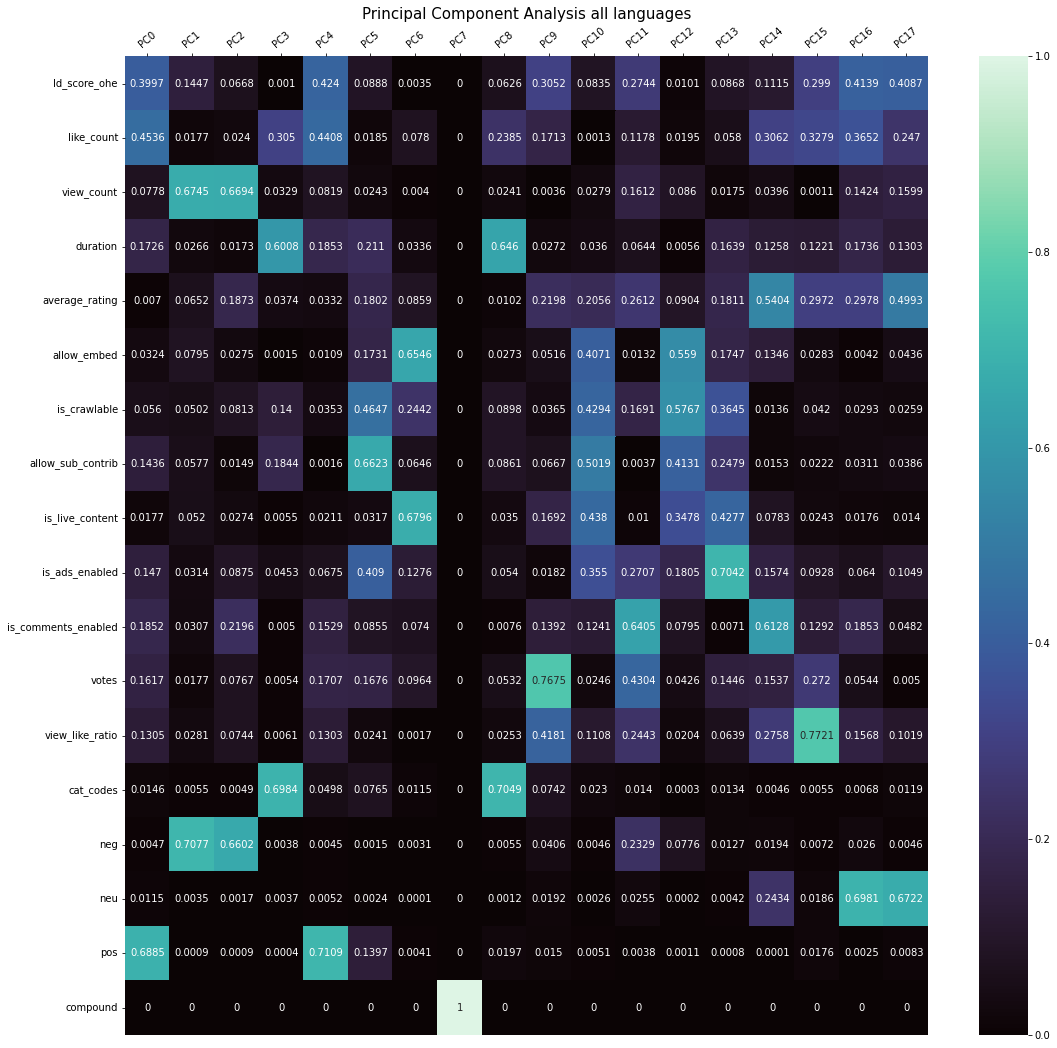

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

pca = PCA(n_components=df_pca_norm.shape[1]).fit(df_pca_norm)
pca_vals = abs(round(pd.DataFrame(pca.components_,columns=['PC%s' % _ for _ in range(len(df_pca_norm.columns))],index=df_pca_norm.columns),5))

plt.figure(figsize=pca_vals.shape)
plt.title("Principal Component Analysis all languages", fontsize =15)
plot=sns.heatmap(pca_vals.round(4),annot=True,fmt='g',cmap='mako')
plot.xaxis.tick_top()
plot.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.setp(labels, rotation=40)
plt.show

In [ ]:
from google.colab import files
 
pca_vals.to_csv('PCAHeatMap.csv', encoding = 'utf-8-sig') 
files.download('PCAHeatMap.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.set_option('display.max_columns', None)

<function matplotlib.pyplot.show>

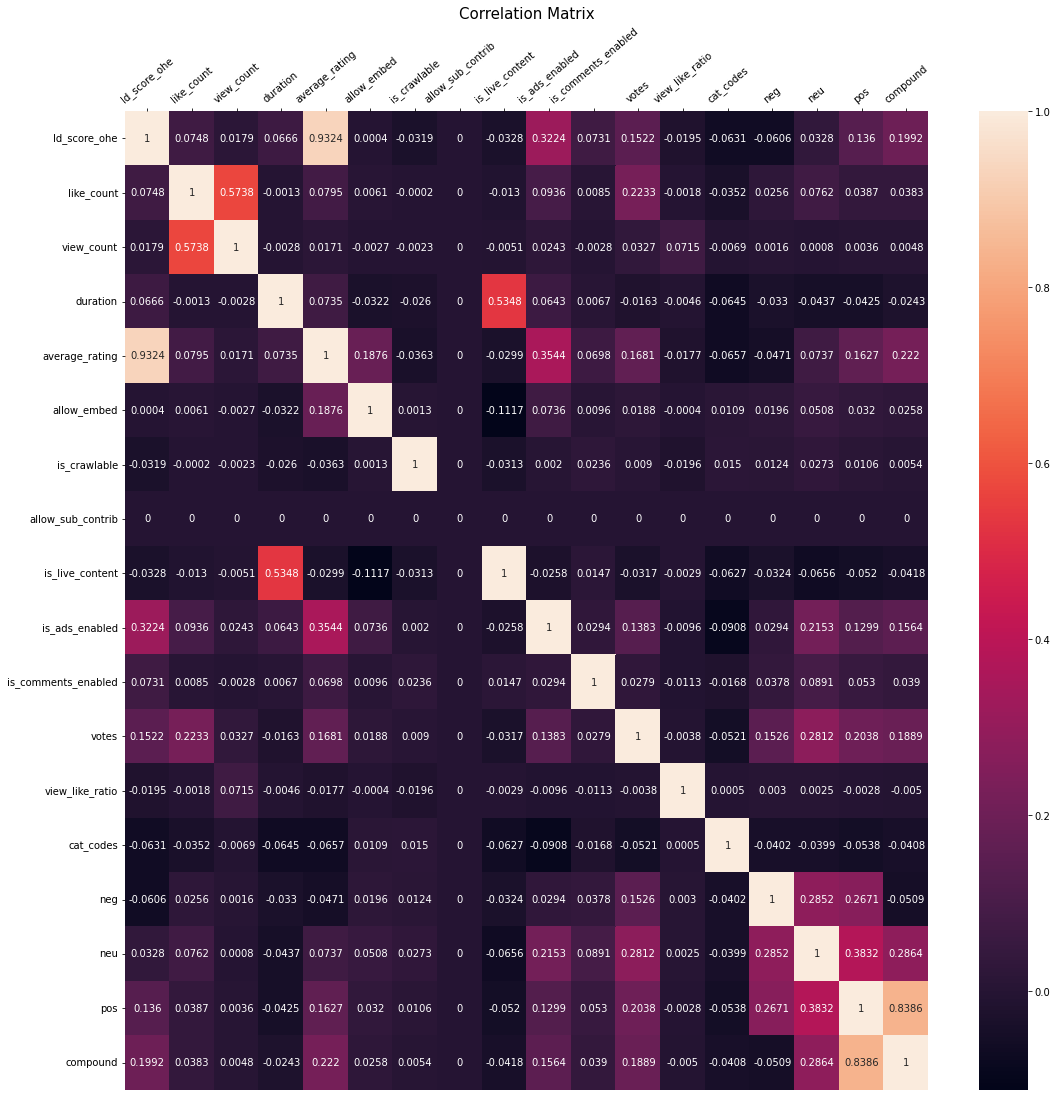

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix=df_pca_norm.corr().replace(np.nan, 0)

plt.figure(figsize=corrMatrix.shape)
plt.title("Correlation Matrix", fontsize =15)
plot=sns.heatmap(corrMatrix.round(4),annot=True,fmt='g')
plot.xaxis.tick_top()
plot.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.setp(labels, rotation=40)
plt.show

In [ ]:
#from google.colab import files
 
#final_df.to_csv('ModelDataWithComments.csv', encoding = 'utf-8-sig') 
#files.download('ModelDataWithComments.csv')